# Predictive Maintenance - Algorithm Selection

## Setup

In [59]:
### IMPORT LIBRARIES
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import SGDClassifier
from sklearn import tree

### READ DATA
##### Needs to be ran from the project directory
train_measurements = pd.read_csv('../datasets/measurements.csv')
train_measurements = train_measurements.sort_values(by=['measurement_time'], ascending=[True])

train_failures = pd.read_csv('../datasets/failures.csv')
train_failures = train_failures.sort_values(by=['failure_time'], ascending=[True])


In [60]:
train_measurements.measurement_time = pd.to_datetime(train_measurements.measurement_time, format="%Y-%m-%d %H:%M:%S")
train_failures.failure_time = pd.to_datetime(train_failures.failure_time)

### MERGE NEXT FAILURE TO MEASUREMENTS
train_combined = pd.merge_asof(
    train_measurements,
    train_failures,
    left_on='measurement_time',
    right_on='failure_time',
    by='gadget_id',
    direction='forward',
)

### TRANSFORM COLUMNS
train_combined['time_to_fail'] = train_combined['failure_time']-train_combined['measurement_time']
train_combined['fail_in_1h'] = np.where(train_combined['time_to_fail']<pd.Timedelta(hours=1), 1, 0)

### CALCULATE RUNNING MEASURES
train_combined = train_combined.reset_index(drop=True)
train_combined = train_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])

train_combined['temperature_6h_std'] = train_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
train_combined['pressure_6h_mean'] = train_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)

train_combined.to_csv('../datasets/train_combined.csv', index=False)

In [61]:
### SPLIT TO TRAIN AND TEST
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = 'fail_in_1h'
cols = X + [y]

df_to_split = train_combined.copy()
df_to_split = df_to_split.dropna(subset=cols)
df_to_split = df_to_split.reset_index(drop=True)


In [62]:
##### Create binary bins to 
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
binner.fit(df_to_split[X])
arr_bins= binner.transform(df_to_split[X])
df_bins = pd.DataFrame(arr_bins)

X = list(df_bins.columns)
cols = X + [y]

df_to_split = pd.concat([df_to_split, df_bins], axis=1)

df_train = df_to_split[df_to_split['gadget_id'].isin([1,2,3,4])].reset_index(drop=True).copy()
df_test = df_to_split[df_to_split['gadget_id'].isin([5,6])].reset_index(drop=True).copy()

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")


Training data: (651, 43)
Test data: (327, 43)


## Algorithms

In [63]:
### PREDICTION PARAMETERS
w0 = 1
w1 = 8
pos_label = 1


In [64]:
### NEURAL NETWORK
nn = MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(10),
    random_state=1,
    max_iter=10000,
    activation='relu',
    tol=0.00001,
)
nn.fit(df_train[X], df_train[y])
df_test['nn'] = nn.predict(df_test[X])


In [65]:
### RANDOM FOREST MODEL
random_forest = RandomForestClassifier(
    min_samples_leaf=7,
    random_state=45,
    n_estimators=50,
    class_weight={0:w0, 1:w1}
)
random_forest.fit(df_train[X], df_train[y])
df_test['rf'] = random_forest.predict(df_test[X])

In [66]:
### LOGISTIC REGRESSION MODEL
log_regr = LogisticRegression(class_weight={0:w0, 1:w1})
log_regr.fit(df_train[X], df_train[y])
df_test['log_regr'] = log_regr.predict(df_test[X])

In [67]:
### LINEAR REGRESSION MODEL
lin_regr = Lasso(alpha=0.1, positive=True)
lin_regr.fit(df_train[X], df_train[y])
df_test['lin_regr'] = lin_regr.predict(df_test[X])
df_test['lin_regr'] = np.where(df_test['lin_regr']>=0.5,1,0)

In [68]:
### KNN MODEL
def knn_weights(knn_y):
    return np.where(knn_y==1, w1, w0)
knn = KNeighborsClassifier(weights=knn_weights)
knn.fit(df_train[X], df_train[y])
df_test['knn'] = knn.predict(df_test[X])

In [69]:
### SVM
svm = SVC(
    class_weight={0:w0, 1:w1},
    C=1,
    random_state=42,
    kernel='linear'
)
svm.fit(df_train[X], df_train[y])
df_test['svm'] = svm.predict(df_test[X])

In [70]:

### NAIVE BAYES
bayes = GaussianNB()
bayes.fit(df_train[X], df_train[y])
df_test['bayes'] = bayes.predict(df_test[X])

In [71]:

clf = SGDClassifier(loss="squared_loss", 
    penalty="l2", 
    max_iter=5)
clf.fit(df_train[X], df_train[y])
df_test['clf'] = clf.predict(df_test[X])

## Results

In [72]:
### PRINT RESULTS
model_summary = []
models = ['rf', 'log_regr', 'lin_regr', 'knn', 'nn', 'svm', 'bayes', 'clf']
for m in models:
    print(f"\n-----------\n{m}")
    try:
        precision = precision_score(df_test['fail_in_1h'], df_test[m], zero_division=0, pos_label=pos_label)
        recall = recall_score(df_test['fail_in_1h'], df_test[m], pos_label=pos_label)
        accuracy = accuracy_score(df_test['fail_in_1h'], df_test[m] )
        conf_matrix = confusion_matrix(df_test['fail_in_1h'], df_test[m] )

        # fpr, tpr, thresholds = roc_curve(df_test['fail_in_1h'], df_test[m])
        # aucscore = auc(fpr, tpr)
        auc = roc_auc_score(df_test['fail_in_1h'], df_test[m])
        f1 = f1_score(df_test['fail_in_1h'], df_test[m])

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n {conf_matrix}")
        print(f"AUC: {auc}\n")
        print(f"f1: {f1}\n")
        print(df_test[m].value_counts())

        model_summary.append({
            'model': m,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'auc': auc,
            'f1': f1
        })

    except:
        print("Can't calculate score")


-----------
rf
Precision: 0.3106796116504854
Recall: 1.0
Accuracy: 0.7828746177370031
Confusion Matrix:
 [[224  71]
 [  0  32]]
AUC: 0.8796610169491526

f1: 0.4740740740740741

0    224
1    103
Name: rf, dtype: int64

-----------
log_regr
Precision: 0.3
Recall: 0.9375
Accuracy: 0.7798165137614679
Confusion Matrix:
 [[225  70]
 [  2  30]]
AUC: 0.8501059322033898

f1: 0.45454545454545453

0    227
1    100
Name: log_regr, dtype: int64

-----------
lin_regr
Precision: 0.0
Recall: 0.0
Accuracy: 0.9021406727828746
Confusion Matrix:
 [[295   0]
 [ 32   0]]
AUC: 0.5

f1: 0.0

0    327
Name: lin_regr, dtype: int64

-----------
knn
Precision: 0.2857142857142857
Recall: 0.0625
Accuracy: 0.8929663608562691
Confusion Matrix:
 [[290   5]
 [ 30   2]]
AUC: 0.5227754237288136

f1: 0.10256410256410256

0    320
1      7
Name: knn, dtype: int64

-----------
nn
Precision: 0.36363636363636365
Recall: 0.125
Accuracy: 0.8929663608562691
Confusion Matrix:
 [[288   7]
 [ 28   4]]
AUC: 0.550635593220339

f1:

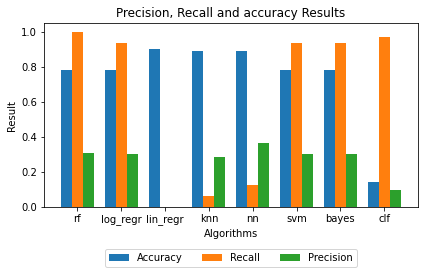

In [125]:
#PRINT RESULT DATAFRAME
#print(df_test[['gadget_id', 'measurement_time'] + cols + models].head(5))

#CREATE IMAGE FOR MODEL COMPARISON
df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, df_summary['accuracy'], width, label='Accuracy')
rects2 = ax.bar(x , df_summary['recall'], width, label='Recall')
rects3 = ax.bar(x + width, df_summary['precision'], width, label='Precision')
# rects4 = ax.bar(x + width, df_summary['auc'], width, label='auc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_xlabel('Algorithms')
ax.set_title('Precision, Recall and accuracy Results')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol = 3)

fig.tight_layout()

plt.savefig('../img/results.png')

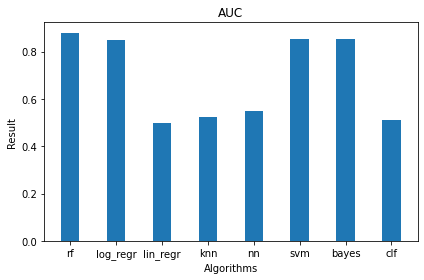

In [130]:
df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x, df_summary['auc'], width, label='auc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_xlabel('Algorithms')
ax.set_title('AUC')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
# ax.legend()

fig.tight_layout()